# Decision trees

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
import pandas as pd

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

## Exercise 1

### Parsing data

In [2]:
bg_test = np.genfromtxt('BDT_background_test.txt')
bg_train = np.genfromtxt('BDT_background_train.txt')
signal_test = np.genfromtxt('BDT_signal_test.txt')
signal_train = np.genfromtxt('BDT_signal_train.txt')

bg_test_x = bg_test[:,0]
bg_test_y = bg_test[:,1]
bg_test_z = bg_test[:,2]
bg_train_x = bg_train[:,0]
bg_train_y = bg_train[:,1]
bg_train_z = bg_train[:,2]

signal_test_x = signal_test[:,0]
signal_test_y = signal_test[:,1]
signal_test_z = signal_test[:,2]
signal_train_x = signal_train[:,0]
signal_train_y = signal_train[:,1]
signal_train_z = signal_train[:,2]

### Plotting data as histograms

Plot the three variables for the signal and background
samples for training:

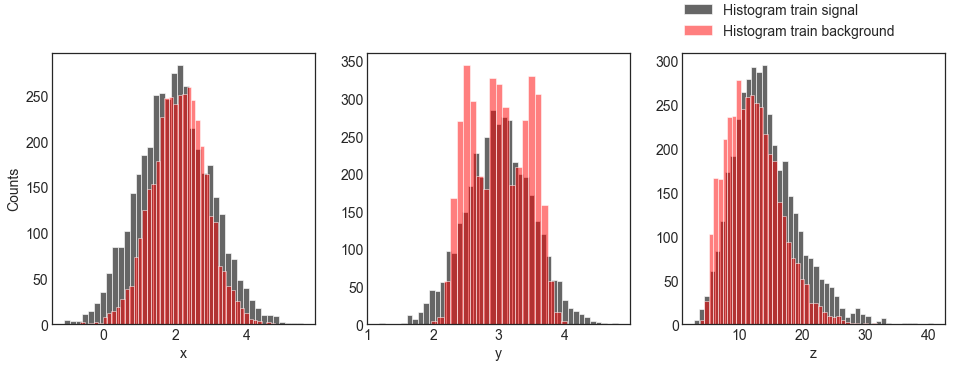

In [3]:
# 1d histograms of background

fig, axs = plt.subplots(1,3, figsize=(16,5))

axs[0].hist(signal_train_x, bins='auto', color='k', label='Histogram train signal', alpha=0.6)
axs[1].hist(signal_train_y, bins='auto', color='k', alpha=0.6)
axs[2].hist(signal_train_z, bins='auto', color='k', alpha=0.6)
axs[0].hist(bg_train_x, bins='auto', color='red', label='Histogram train background', alpha=0.5)
axs[1].hist(bg_train_y, bins='auto', color='red', alpha=0.5)
axs[2].hist(bg_train_z, bins='auto', color='red', alpha=0.5)
axs[0].set_xlabel('x')
axs[1].set_xlabel('y')
axs[2].set_xlabel('z')
axs[0].set_ylabel('Counts')
axs[0].set_ylabel('Counts')
fig.legend(loc=(0.71,0.88));

### Plot data as 2d scatter plots

**Training data**

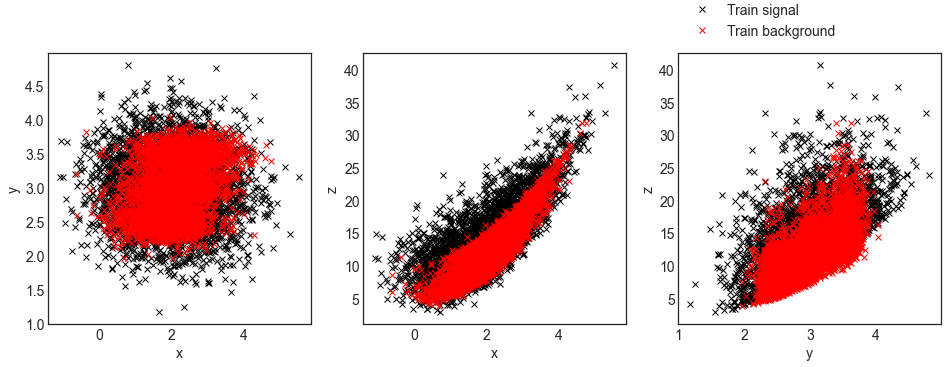

In [4]:
fig, axs = plt.subplots(1,3, figsize=(16,5))

axs[0].plot(signal_train_x, signal_train_y, 'kx', label='Train signal')
axs[1].plot(signal_train_x, signal_train_z, 'kx')
axs[2].plot(signal_train_y, signal_train_z, 'kx')
axs[0].plot(bg_train_x, bg_train_y, 'rx', label='Train background')
axs[1].plot(bg_train_x, bg_train_z, 'rx')
axs[2].plot(bg_train_y, bg_train_z, 'rx')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')
axs[2].set_xlabel('y')
axs[0].set_ylabel('y')
axs[1].set_ylabel('z')
axs[2].set_ylabel('z')
fig.legend(loc=(0.72,0.88));

**Testing data**

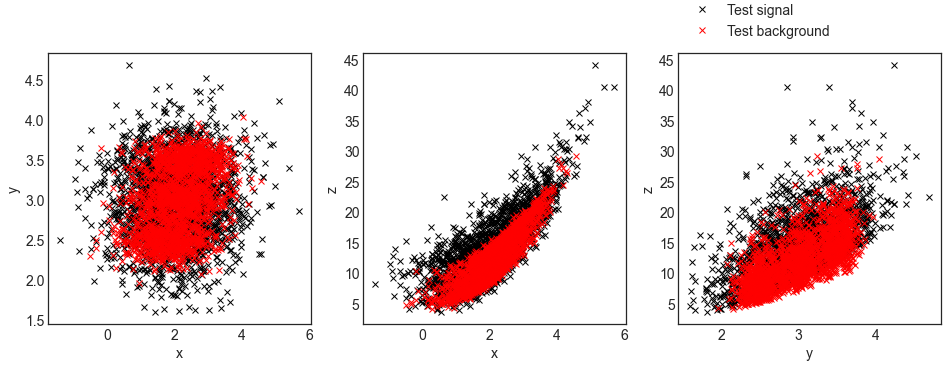

In [5]:
fig, axs = plt.subplots(1,3, figsize=(16,5))

axs[0].plot(signal_test_x, signal_test_y, 'kx', label='Test signal')
axs[1].plot(signal_test_x, signal_test_z, 'kx')
axs[2].plot(signal_test_y, signal_test_z, 'kx')
axs[0].plot(bg_test_x, bg_test_y, 'rx', label='Test background')
axs[1].plot(bg_test_x, bg_test_z, 'rx')
axs[2].plot(bg_test_y, bg_test_z, 'rx')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')
axs[2].set_xlabel('y')
axs[0].set_ylabel('y')
axs[1].set_ylabel('z')
axs[2].set_ylabel('z')
fig.legend(loc=(0.72,0.88));

### Training and testing the BDT

Make one array containing all training data and one array containing all test data. Make one array with values 1 (for signals) and 0 (for background).

In [6]:
train = np.concatenate((signal_train, bg_train))
train_class = np.concatenate((np.ones(len(signal_train)), np.zeros(len(bg_train))))

test = np.concatenate((signal_test, bg_test))
test_class = np.concatenate((np.ones(len(signal_test)), np.zeros(len(bg_test))))

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME", n_estimators=200)
clf = clf.fit(train, train_class)

# Testing data
twoclass_output = clf.decision_function(test)

### Plotting the result

plot the BDT decision score for the
test sample separated by color for the signal and
background

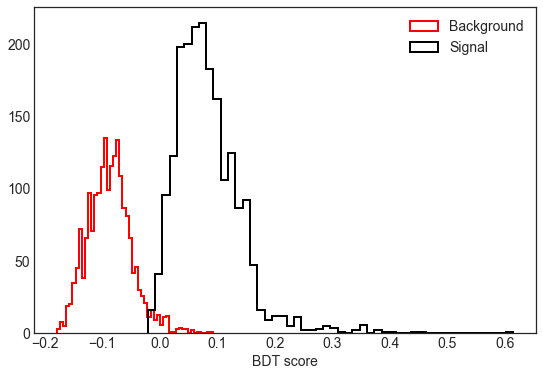

In [8]:
fig, ax = plt.subplots(figsize=(9,6))

ax.hist(twoclass_output[test_class==0], bins=50, label='Background', histtype='step', linewidth=2, color='red')
ax.hist(twoclass_output[test_class==1], bins=50, label='Signal', histtype='step', linewidth=2, color='black')
ax.set_xlabel('BDT score')
ax.legend();

## Exercise 2

In [9]:
from sklearn.model_selection import train_test_split

# X data train and test
var16 = np.genfromtxt('BDT_16var.txt')
var16_train_X = var16[:int(len(var16)*0.85)][:,1:] # first 85% rows and all except first column
var16_test_X = var16[int(len(var16)*0.85):][:,1:]  # last 15% rows and all except first column

# Check that you did not split a signal/background "pair"
print('Needs to same index:', var16[int(len(var16)*0.85)][0], var16[int(len(var16)*0.85)+1][0])

# Y data train and test
# every second element is signal / background
var16_train_Y = np.zeros(8500, dtype=int)
var16_train_Y[::2]=1
var16_test_Y = np.zeros(1500, dtype=int)
var16_test_Y[::2]=1

Needs to same index: 4250.0 4250.0


### Plot data for one of the variables to see if the distribution of the training and test data are alike

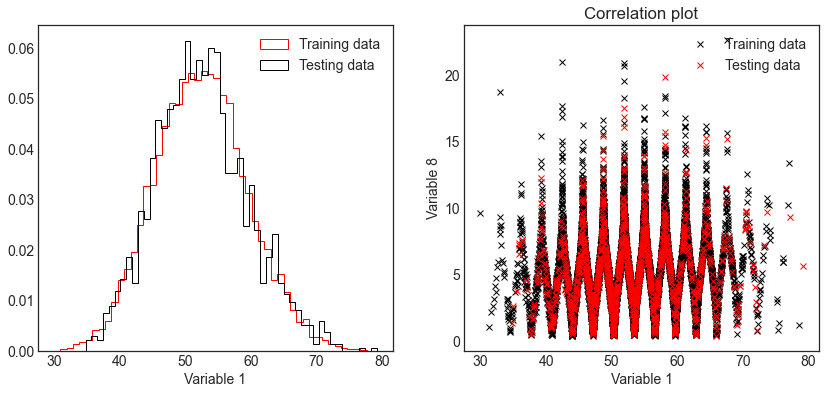

In [10]:
idx1, idx2 = 1, 8

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,6))
ax0.hist(var16_train_X[:,idx1], bins=50, label='Training data', histtype='step', density=True, color='red')
ax0.hist(var16_test_X[:,idx1], bins=50, label='Testing data', histtype='step', density=True, color='black')
ax0.set_xlabel('Variable %s' %(idx1))
ax0.legend()

ax1.set_title('Correlation plot')
ax1.plot(var16_train_X[:,idx1], var16_train_X[:,idx2], 'kx', label='Training data')
ax1.plot(var16_test_X[:,idx1], var16_test_X[:,idx2], 'rx', label='Testing data')
ax1.legend()
ax1.set_xlabel('Variable %s' %(idx1))
ax1.set_ylabel('Variable %s' %(idx2));

In [11]:
# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME", n_estimators=300)
clf = clf.fit(var16_train_X, var16_train_Y)

# Testing data
twoclass_output = clf.decision_function(var16_test_X)

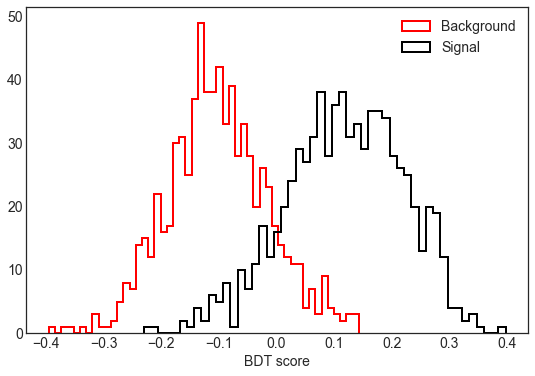

In [12]:
fig, ax = plt.subplots(figsize=(9,6))

ax.hist(twoclass_output[var16_test_Y==0], bins=50, label='Background', histtype='step', linewidth=2, color='red')
ax.hist(twoclass_output[var16_test_Y==1], bins=50, label='Signal', histtype='step', linewidth=2, color='black')
ax.set_xlabel('BDT score')
ax.legend();

### Are any variables essentially worthless? What happens when the lowest rank variable is removed from the training?

In [ ]:
y_true = var16_test_Y
y_score = twoclass_output

from sklearn.metrics import label_ranking_loss
#label_ranking_loss(y_true, y_score)

In [ ]:
correlation_matrix = np.ones(shape=(16,16))

for i in range(16):
    for j in range(16):
        X, Y = var16[:,1:][:,i], var16[:,1:][:,j]
        correlation_matrix[i][j] = aas.correlation(X, Y)

In [ ]:
thres = 0.01

for i in range(16):
    N_corr = len(np.where(abs(correlation_matrix[i]) > thres)[0])-1
    print(f'Paramter {i} is correlated with {N_corr} other parameters')

In [ ]:
df_var16 = pd.DataFrame(var16[:, 1:])

In [ ]:
df_var16.rank(axis=1, pct = True)

In [ ]:
idx1, idx2 = 11, 0

for i in range(16):
    X, Y = var16[:,1:][:,idx1], var16[:,1:][:,i]
    #fig, ax = plt.subplots(figsize=(7,6))
    #aas.correlation_plot(X, Y, N_bins=90, fig=fig, ax=ax, xlabel='X', ylabel='Y', d_xy=[0.05, 0.36])

## Problem from 2016 exam

A cancer study in 1991 conducted in Wisconsin collected data
from ~700 patients. There were 9 variables associated with the
digitized image of a fine needle aspirate biopsy sample of a
tissue mass. Each variable has discrete values from 1-10. There
was also the patient identifier (code number) and whether the
sample mass was ultimately benign or malignant.

### Problem a
**Using some method (straight cuts, support vector machine,
boosted decision tree, etc.) and the training data, come up
with a classification algorithm which uses the 9 variables to
identify malignant and benign tissue samples**

In [14]:
# first column is ID number and last column is benign(2)/malignant(4)
train_X = np.genfromtxt('breast-cancer-wisconsin_train-test.txt')[:,1:-1]
train_Y = np.genfromtxt('breast-cancer-wisconsin_train-test.txt')[:,-1]

test_X = np.genfromtxt('breast-cancer-wisconsin_mod_real.txt')[:,1:]
#test_Y = np.genfromtxt('breast-cancer-wisconsin_mod_real.txt')[:,-1]

### Plot data for one of the variables to see if the distribution of the training and test data are alike

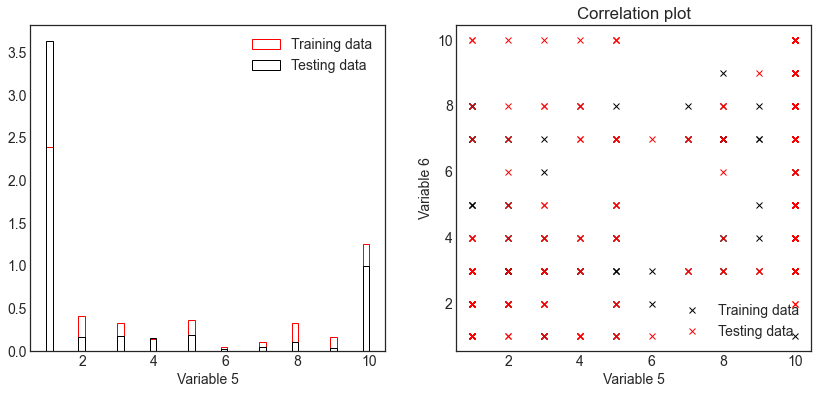

In [15]:
idx1, idx2 = 5, 6

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,6))
ax0.hist(train_X[:,idx1], bins=50, label='Training data', histtype='step', density=True, color='red')
ax0.hist(test_X[:,idx1], bins=50, label='Testing data', histtype='step', density=True, color='black')
ax0.set_xlabel('Variable %s' %(idx1))
ax0.legend()

ax1.set_title('Correlation plot')
ax1.plot(train_X[:,idx1], train_X[:,idx2], 'kx', label='Training data')
ax1.plot(test_X[:,idx1], test_X[:,idx2], 'rx', label='Testing data')
ax1.legend()
ax1.set_xlabel('Variable %s' %(idx1))
ax1.set_ylabel('Variable %s' %(idx2));

#### Training and testing TRAINING DATA

**With a developed algorithm, run the classifier over the
training sample and calculate the efficiency (true positive
rate) of identifying a malignant mass**

In [64]:
# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=10)
clf = clf.fit(train_X, train_Y)

# Testing TRAINING DATA
twoclass_output_train = clf.decision_function(train_X)

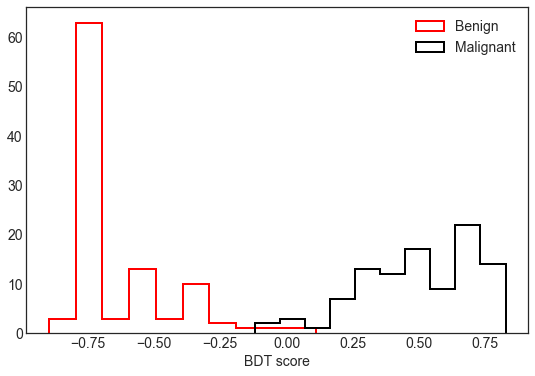

In [65]:
fig, ax = plt.subplots(figsize=(9,6))

ax.hist(twoclass_output_train[train_Y==2], bins=10, label='Benign', histtype='step', linewidth=2, color='red')
ax.hist(twoclass_output_train[train_Y==4], bins=10, label='Malignant', histtype='step', linewidth=2, color='black')
ax.set_xlabel('BDT score')
ax.legend();

In [66]:
# Testing TESTING DATA
#twoclass_output = clf.decision_function(test_X)

In [67]:
twoclass_output_train[twoclass_output_train>0]=4
twoclass_output_train[twoclass_output_train<0]=2

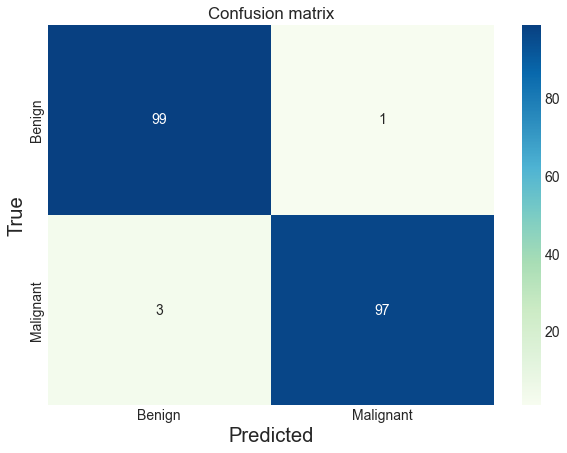

In [68]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 7))
matrix_conf = confusion_matrix(train_Y, twoclass_output_train)
sns_plot = sns.heatmap(
    matrix_conf,
    annot=True,
    cmap='GnBu',
    xticklabels=['Benign', 'Malignant'],
    yticklabels=['Benign', 'Malignant'],
    fmt="d",
    annot_kws={"fontsize": 14}
)
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
plt.title("Confusion matrix");

**Top left** True negatives: benign classified as benign

**Top right** False positives: benign classified as malignant

**Bottom left** False negatives: malignant classified as benign

**Bottom right** True positives: malignant classified as malignant

In [69]:
tn, fp, fn, tp = matrix_conf.ravel()
print('True negative', tn, 
      '\nFalse positive', fp, 
      '\nFalse negative',fn,
      '\nTrue positive', tp)

True negative 99 
False positive 1 
False negative 3 
True positive 97


**True positive rate** TPR = TP/(TP+FN)

In [70]:
def TPR(tp, fn):
    'True positive rate'
    return tp/(tp+fn)

In [71]:
tpr = TPR(tp, fn)
print('True positive rate =', tpr)

True positive rate = 0.97


## Problem b - use your algorithm on the test data

**Using the same setting(s) as developed in Problem 2a, run
the classifier over all the entries in the blind sample**

In [72]:
# Testing TESTING DATA
twoclass_output_test = clf.decision_function(test_X)
twoclass_output_test[twoclass_output_test>0]=4
twoclass_output_test[twoclass_output_test<0]=2

**Produce a text file which contains only the ID of the samples which
your classifier classifies as malignant**


In [73]:
IDs = np.genfromtxt('breast-cancer-wisconsin_mod_real.txt')[:,0] # 
IDs_benign = IDs[twoclass_output_test == 2]
IDs_malignant = IDs[twoclass_output_test == 4]

#np.savetxt('Wilson.benign_ID', IDs_benign)
#np.savetxt('Wilson.malignant_ID', IDs_malignant)

**Compare your results with the true values**

In [76]:
IDs_benign_true = np.genfromtxt('benign_true.txt')[:,0]
IDs_malignant_true = np.genfromtxt('malignant_true.txt')[:,0]

overlap_ben = len(np.intersect1d(IDs_benign_true, IDs_benign))
overlap_mal = len(np.intersect1d(IDs_malignant_true, IDs_malignant))

print("N overlap benign: ", overlap_ben)
print("N overlap malignant: ", overlap_mal)
print("efficiency: ", (overlap_mal+overlap_ben)*1.0/(len(IDs_malignant_true)+len(IDs_benign_true)))

N overlap benign:  303
N overlap malignant:  133
efficiency:  0.9026915113871635
